In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# import os
# import shutil

# val_dir = './tiny-imagenet-200/val'
# annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# # Create a new directory for the restructured validation set
# new_val_dir = os.path.join(val_dir, 'images_restructured')
# os.makedirs(new_val_dir, exist_ok=True)

# # Read the annotations file and move images to respective class folders
# with open(annotations_file, 'r') as f:
#     for line in f:
#         parts = line.strip().split('\t')
#         img_name, img_class = parts[0], parts[1]
        
#         class_dir = os.path.join(new_val_dir, img_class)
#         os.makedirs(class_dir, exist_ok=True)
        
#         src_path = os.path.join(val_dir, 'images', img_name)
#         dst_path = os.path.join(class_dir, img_name)
        
#         try:
#             shutil.move(src_path, dst_path)
#         except FileNotFoundError:
#             print(f"File {src_path} not found. Skipping...")


In [4]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(64, padding=4),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val/images_restructured'

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8)

testset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=8)


In [5]:
# Modify VGG16 for CIFAR-10
model = vgg16(pretrained=True).to(device)  # Move model to GPU
model.classifier[6] = nn.Linear(4096, 200).to(device)  # Replace last layer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, 'min')
scaler = GradScaler()


c:\Users\William Zhang\.conda\envs\search_sense\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\William Zhang\.conda\envs\search_sense\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # Use autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        if i % 100 == 99:  # Print average loss every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Step the scheduler based on the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    scheduler.step(val_loss / len(testloader))

print("Finished Training")

[1, 100] loss: 5.364
[1, 200] loss: 5.293
[1, 300] loss: 5.253
[2, 100] loss: 5.170
[2, 200] loss: 5.091
[2, 300] loss: 4.970
[3, 100] loss: 4.457
[3, 200] loss: 4.121
[3, 300] loss: 3.819
[4, 100] loss: 3.349
[4, 200] loss: 3.201
[4, 300] loss: 3.062
[5, 100] loss: 2.850
[5, 200] loss: 2.775
[5, 300] loss: 2.658
[6, 100] loss: 2.551
[6, 200] loss: 2.511
[6, 300] loss: 2.450
[7, 100] loss: 2.349
[7, 200] loss: 2.317
[7, 300] loss: 2.300
[8, 100] loss: 2.218
[8, 200] loss: 2.202
[8, 300] loss: 2.176
[9, 100] loss: 2.119
[9, 200] loss: 2.119
[9, 300] loss: 2.091
[10, 100] loss: 2.056
[10, 200] loss: 2.038
[10, 300] loss: 2.025
[11, 100] loss: 1.975
[11, 200] loss: 1.966
[11, 300] loss: 1.973
[12, 100] loss: 1.931
[12, 200] loss: 1.914
[12, 300] loss: 1.896
[13, 100] loss: 1.895
[13, 200] loss: 1.867
[13, 300] loss: 1.863
[14, 100] loss: 1.828
[14, 200] loss: 1.834
[14, 300] loss: 1.853
[15, 100] loss: 1.802
[15, 200] loss: 1.782
[15, 300] loss: 1.796
[16, 100] loss: 1.755
[16, 200] loss:

In [8]:
torch.save(model.state_dict(), 'model.pth.tar')

In [7]:
def extract_batch_features(inputs, model):
    with torch.no_grad():
        features = model.features(inputs)
    features = features.view(features.size(0), -1)
    return features.cpu()  # Move features back to CPU for further processing

# Extract features for the entire CIFAR-10 test dataset
feature_list = []

for inputs, _ in testloader:
    inputs = inputs.to(device)
    features = extract_batch_features(inputs, model)
    feature_list.append(features)

# Convert the list of tensors to a single tensor
feature_tensor = torch.cat(feature_list, dim=0)

# Convert the tensor to a numpy array
feature_array = feature_tensor.numpy()

print(feature_array.shape)  # This should print (10000, [feature_dimension])


(8823, 25088)


In [9]:
from sklearn.cluster import KMeans
import numpy as np

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feature_array)

cluster_assignments = kmeans.labels_

c:\Users\William Zhang\.conda\envs\search_sense\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
image_list = []

for inputs, _ in testloader:
    image_list.extend(inputs.cpu().numpy())

In [9]:
cluster_to_images = {i: [] for i in range(n_clusters)}

for i, cluster_id in enumerate(cluster_assignments):
    cluster_to_images[cluster_id].append(image_list[i])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

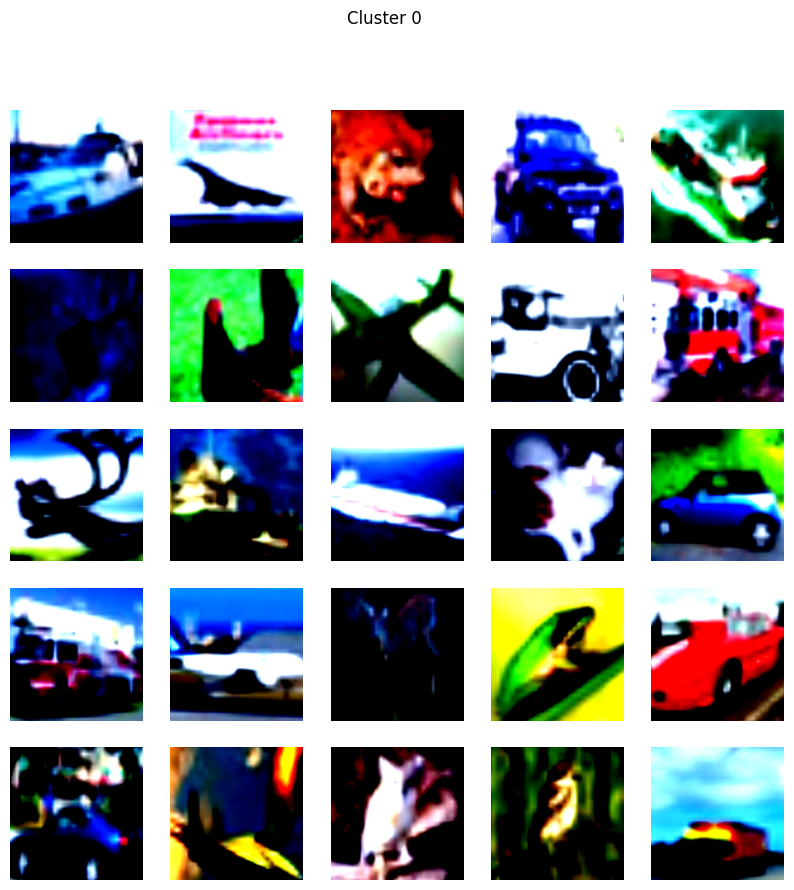

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

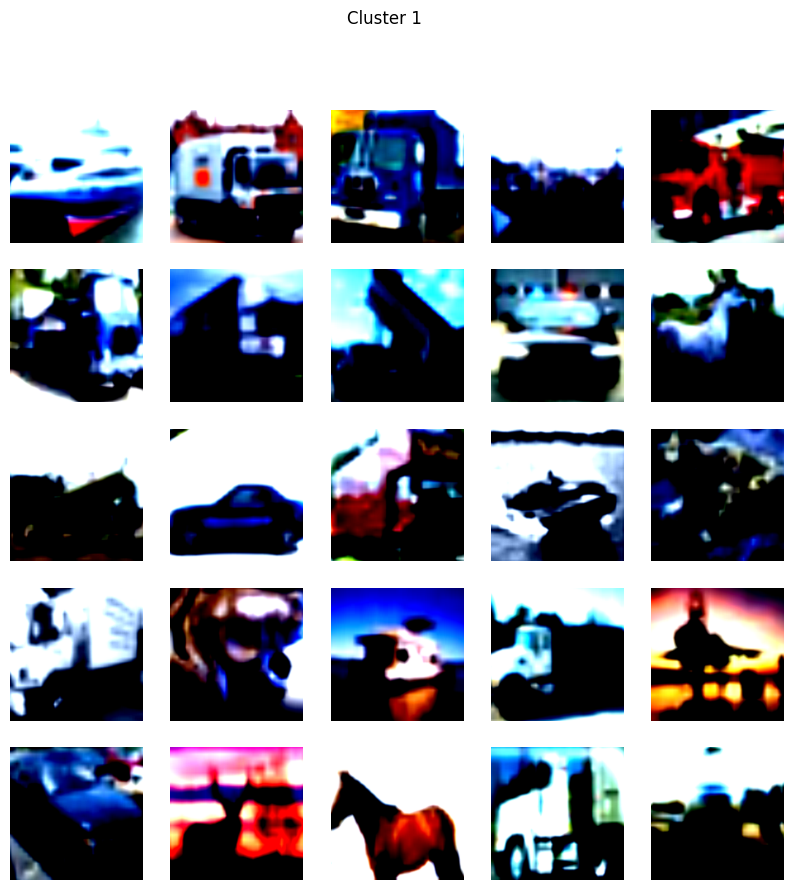

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

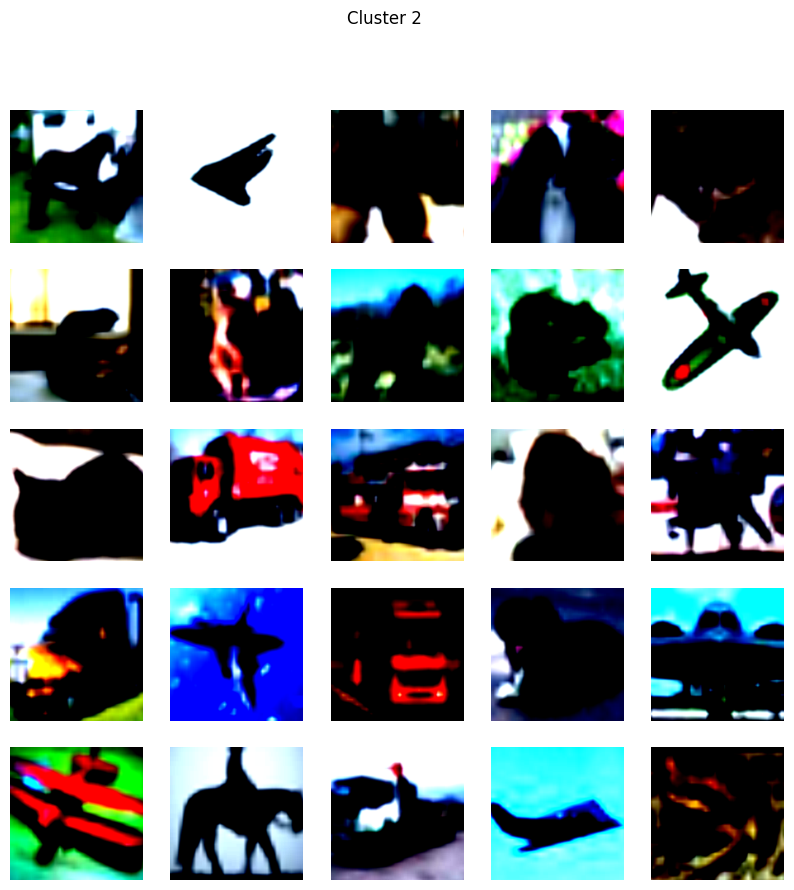

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

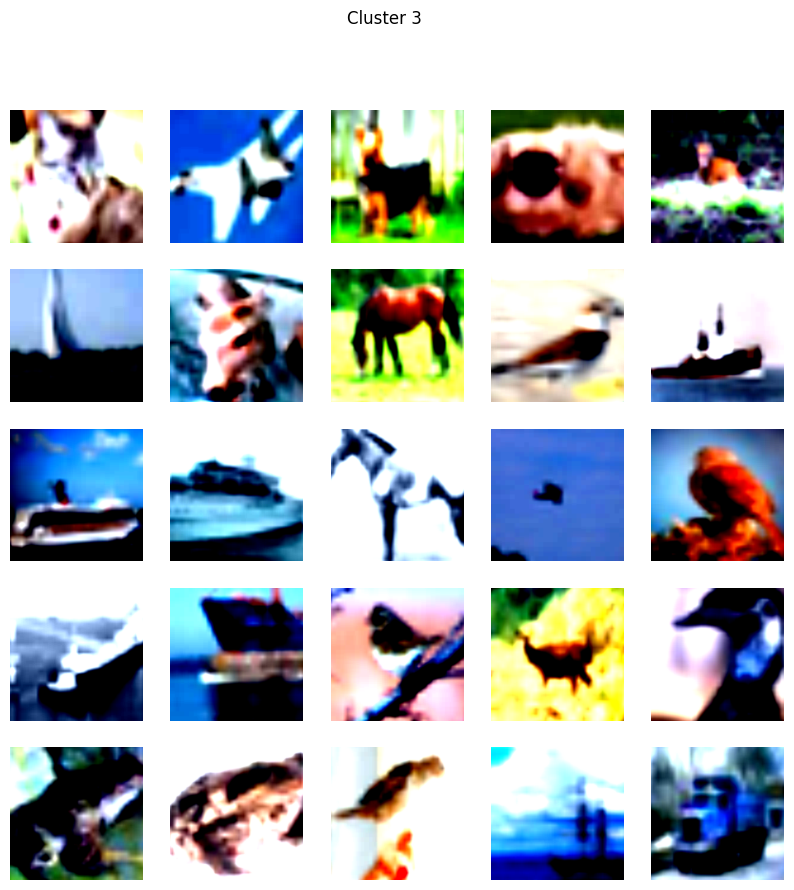

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

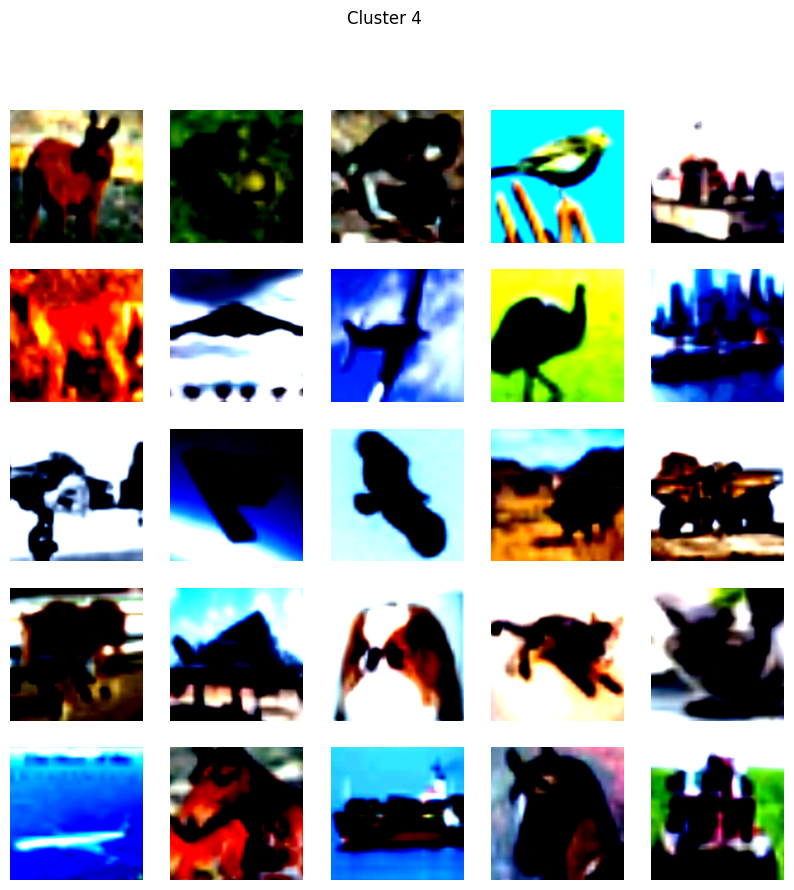

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

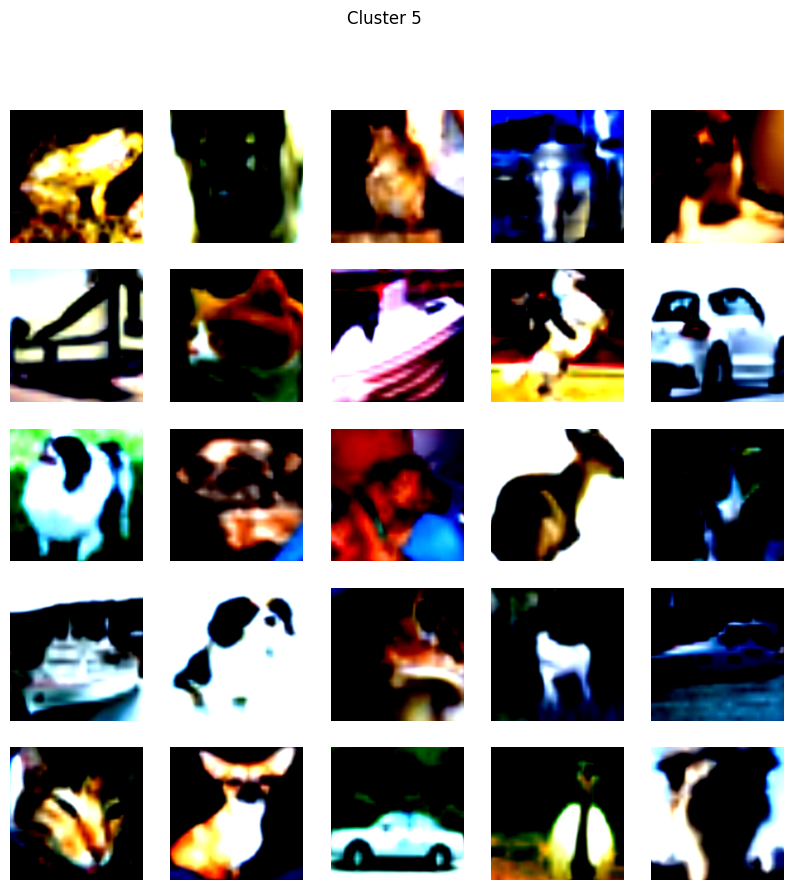

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

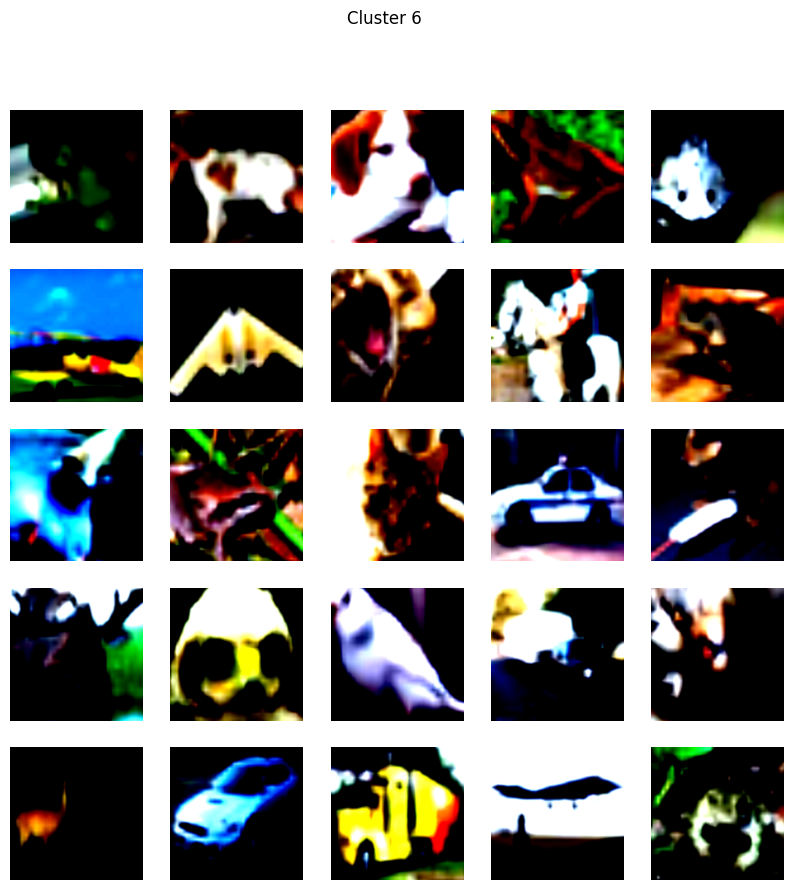

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

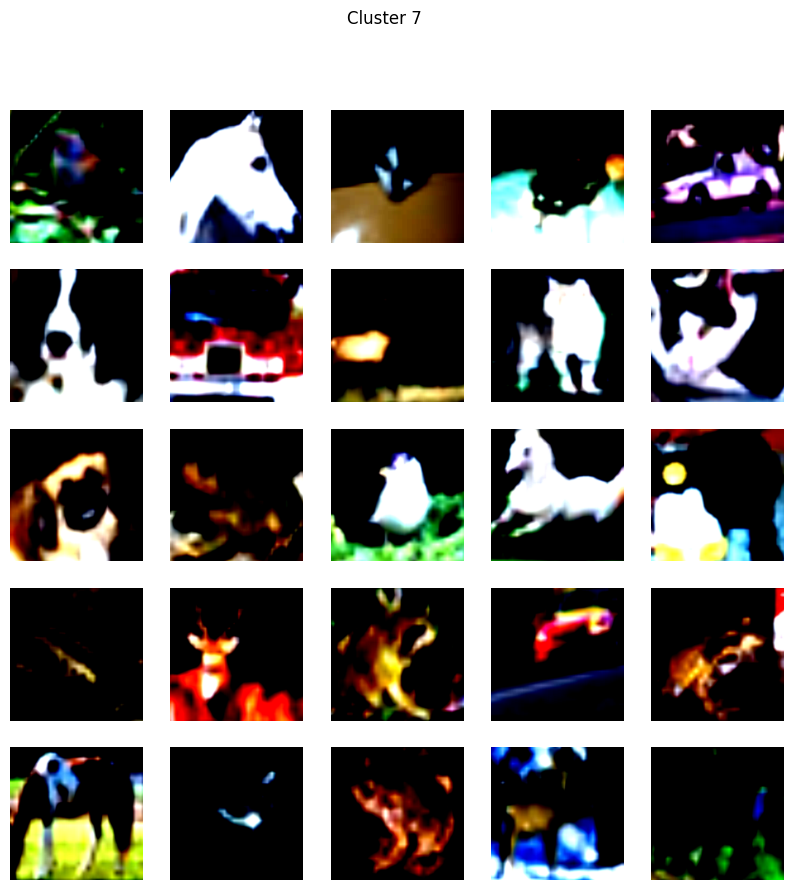

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

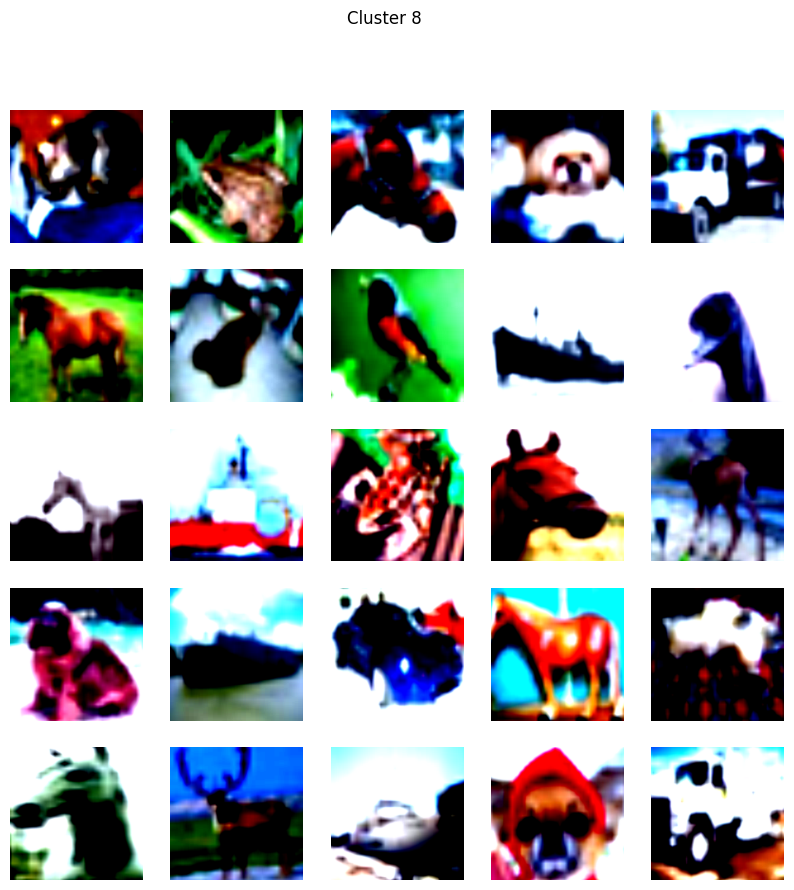

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

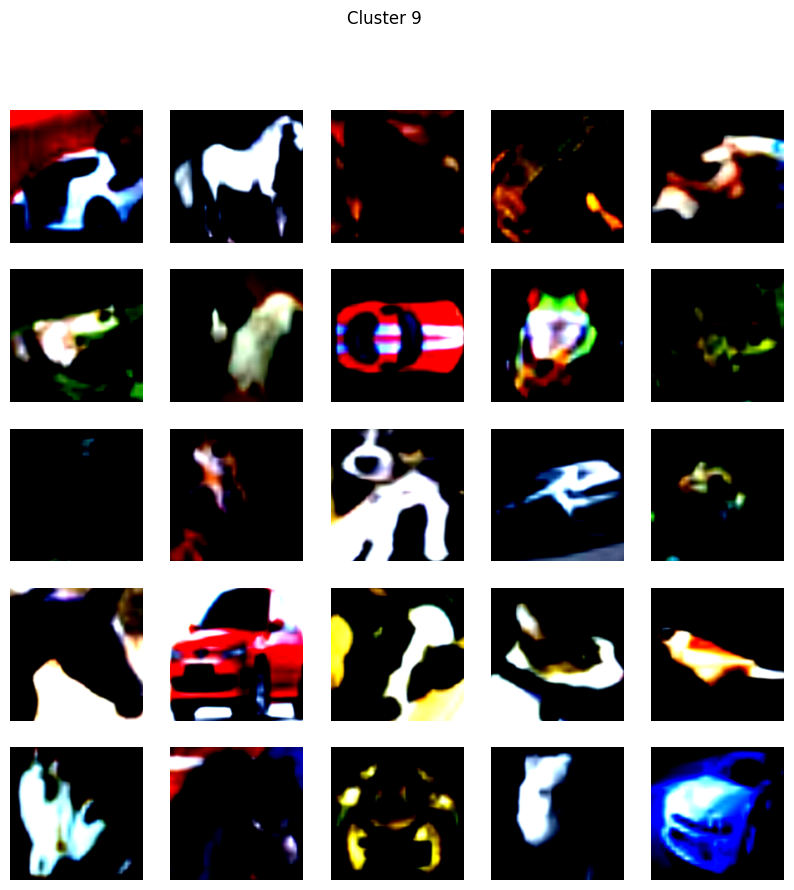

In [10]:
import matplotlib.pyplot as plt

for cluster_id, images in cluster_to_images.items():
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images[:25]):  # Displaying first 25 images from each cluster
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.transpose(1, 2, 0))  # Convert from CxHxW to HxWxC
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()
